<a href="https://colab.research.google.com/github/Aquib88raza/image-classification-ANKLE/blob/main/rf94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/10
4/4 [==============================] - 30s 6s/step - loss: 0.6719 - accuracy: 0.5826 - val_loss: 0.6545 - val_accuracy: 0.5862
Epoch 2/10
4/4 [==============================] - 27s 7s/step - loss: 0.5880 - accuracy: 0.6783 - val_loss: 0.6367 - val_accuracy: 0.5862
Epoch 3/10
4/4 [==============================] - 23s 6s/step - loss: 0.5139 - accuracy: 0.7739 - val_loss: 0.6584 - val_accuracy: 0.5862
Epoch 4/10
4/4 [==============================] - 23s 6s/step - loss: 0.4606 - accuracy: 0.8609 - val_loss: 0.5858 - val_accuracy: 0.7586
Epoch 5/10
4/4 [==============================] - 23s 5s/step - loss: 0.4242 - accuracy: 0.8522 - val_loss: 0.5715 - val_accuracy: 0.6897
Epoch 6/10
4/4 [==============================] - 27s 7s/step - loss: 0.3828 - accuracy: 0.8783 - val_loss: 0.5724 - val_accuracy: 0.7241
Epoch 7/10
4/4 [==============================] - 23s 6s/step - loss: 0.3616 - accuracy: 0.8957 - val_loss: 0.5730 - val_accuracy: 0.6897
Epoch 8/10
4/4 [==================

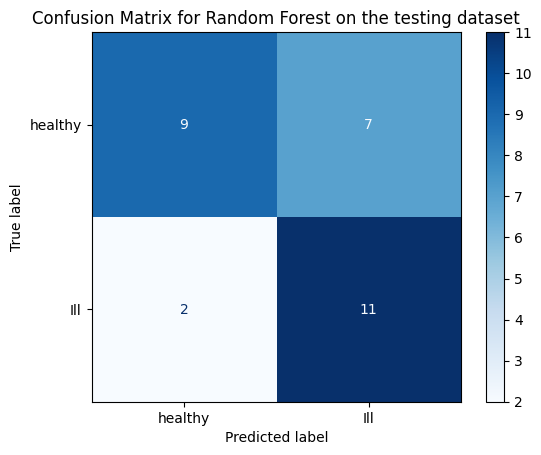

In [ ]:
import os
import numpy as np
import cv2
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the path to your image directories for healthy and ill samples
normal_path = "/content/drive/MyDrive/Ankle_balance/normal"
ill_path = "/content/drive/MyDrive/Ankle_balance/ill"

# Create lists to store image data and labels
dataset_images = []
dataset_labels = []

# ImageDataGenerator for preprocessing and augmentation
datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Flow images from directories, augmenting and appending them to the dataset
for directory in [normal_path, ill_path]:
    for files in os.listdir(directory):
        if files.endswith(".jpg"):
            file_path = os.path.join(directory, files)
            image = cv2.imread(file_path)
            if image is not None and not image.size == 0:
                size = (256, 256)  # Define the size for resizing images (InceptionV3 input size)
                image = cv2.resize(image, size, interpolation=cv2.INTER_AREA)
                image = np.expand_dims(image, axis=0)
                for batch in datagen.flow(image, batch_size=1):
                    dataset_images.append(np.squeeze(batch, axis=0))
                    dataset_labels.append(0 if directory == normal_path else 1)  # Label for healthy or ill images
                    break  # break to ensure one image per file

# Convert the lists to NumPy arrays
dataset_images = np.array(dataset_images)
dataset_labels = np.array(dataset_labels)

seed = 42  # You can use any integer value as the seed
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(dataset_images, dataset_labels, test_size=0.2, random_state=seed)

# Create an InceptionV3 model for feature extraction
base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(256, 256, 3))

# Add custom layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze layers in the base model
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the InceptionV3-based model on the training dataset
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Extract features from the InceptionV3-based model for both training and testing datasets
X_train_features = model.predict(X_train)
X_test_features = model.predict(X_test)

# Apply Principal Component Analysis (PCA) to reduce dimensionality
n_components = min(X_train_features.shape[0], X_train_features.shape[1])  # Set it to the minimum
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_features)
X_test_pca = pca.transform(X_test_features)

# Fit Random Forest classifier on PCA features
random_forest = RandomForestClassifier()

# Perform grid search with cross-validation
param_grid = {
    'n_estimators': [100, 300, 500],  # Number of trees in the forest
    'max_depth': [None, 10, 30, 50],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_rf = GridSearchCV(random_forest, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the training data with PCA features
grid_search_rf.fit(X_train_pca, y_train)

# Get the best parameters and best accuracy
best_params_rf = grid_search_rf.best_params_
best_accuracy_rf = grid_search_rf.best_score_

print("Best Parameters for Random Forest:", best_params_rf)
print("Best Accuracy for Random Forest:", best_accuracy_rf)

# Predict on the testing dataset using the best Random Forest classifier with PCA features
best_rf_classifier = grid_search_rf.best_estimator_
y_test_pred_rf = best_rf_classifier.predict(X_test_pca)

# Generate classification report for the testing dataset
test_report_rf = classification_report(y_test, y_test_pred_rf)
print("Classification Report for Random Forest on the testing dataset:\n", test_report_rf)

# Calculate the confusion matrix for the testing dataset
test_cm_rf = confusion_matrix(y_test, y_test_pred_rf)

# Display the confusion matrix for the testing dataset
test_disp_rf = ConfusionMatrixDisplay(confusion_matrix=test_cm_rf, display_labels=["healthy", "Ill"])
test_disp_rf.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Random Forest on the testing dataset")
plt.show()




Classification Report for Random Forest on the training dataset:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        56
           1       1.00      0.98      0.99        59

    accuracy                           0.99       115
   macro avg       0.99      0.99      0.99       115
weighted avg       0.99      0.99      0.99       115



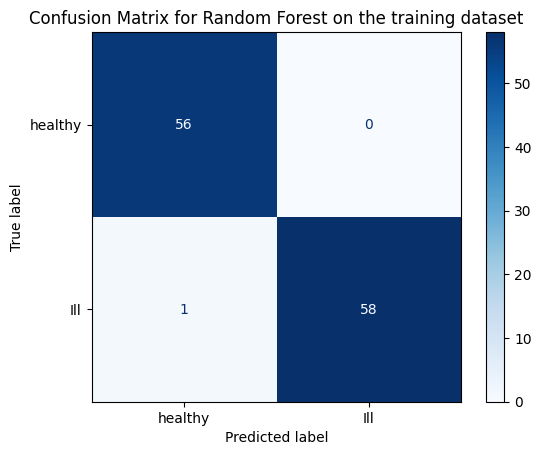

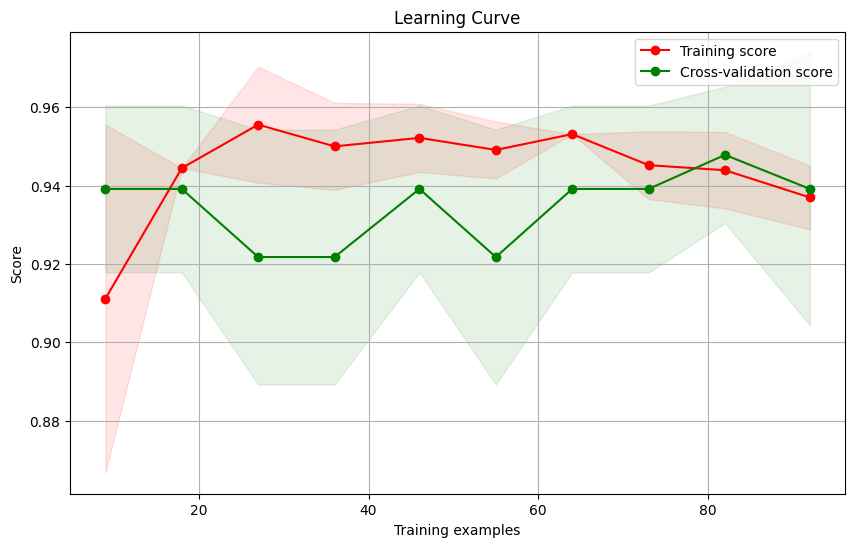

In [ ]:
# Predict on the training dataset using the best Random Forest classifier with PCA features
y_train_pred_rf = best_rf_classifier.predict(X_train_pca)

# Generate classification report for the training dataset
train_report_rf = classification_report(y_train, y_train_pred_rf)
print("Classification Report for Random Forest on the training dataset:\n", train_report_rf)

# Calculate the confusion matrix for the training dataset
train_cm_rf = confusion_matrix(y_train, y_train_pred_rf)

# Display the confusion matrix for the training dataset
train_disp_rf = ConfusionMatrixDisplay(confusion_matrix=train_cm_rf, display_labels=["healthy", "Ill"])
train_disp_rf.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Random Forest on the training dataset")
plt.show()

# Plot the learning curve
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    best_svm_classifier, X_train_pca, y_train, cv=5, train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1,
                 color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.legend(loc="best")
plt.show()